In [1]:
import warnings 
warnings.filterwarnings('ignore')
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
import statsmodels.api as sm
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

color = sns.color_palette()
sns.set_style('darkgrid')

In [2]:
from subprocess import check_output
print(check_output(['ls', '.']).decode('utf-8'))

Untitled.ipynb



In [3]:
data = pd.read_csv('/Users/kshitija/Downloads/australian-stores-demand-forecasting/train.csv')
data['Date'] = pd.to_datetime(data['Date'], format="%d-%b-%y")
data.head()

,Date,Store,Item,Sales
0,2017-01-01,KMart,1,13
1,2017-01-02,KMart,1,11
2,2017-01-03,KMart,1,14
3,2017-01-04,KMart,1,13
4,2017-01-05,KMart,1,10


In [4]:
# from sklearn.model_selection import train_test_split

# train, test = train_test_split(data, test_size=0.3, random_state=25)
# print(f"No. of training examples: {train.shape[0]}")
# print(f"No. of testing examples: {test.shape[0]}")

<AxesSubplot:xlabel='Date', ylabel='Sales'>

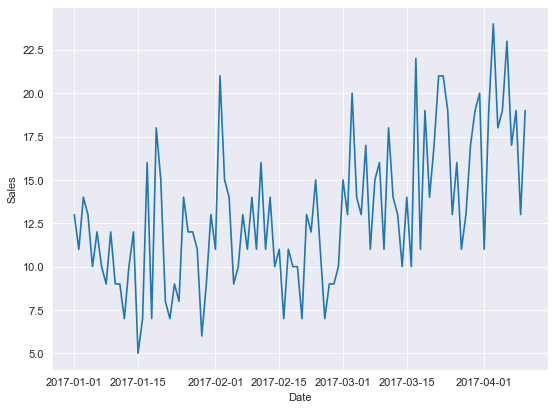

In [5]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)

sns.lineplot(x="Date", y="Sales",legend = 'full' , data=data[:100])

In [6]:
data['year'] = data['Date'].dt.year
data['month'] = data['Date'].dt.month
data['day'] = data['Date'].dt.dayofyear
data['weekday'] = data['Date'].dt.weekday
data

,Date,Store,Item,Sales,year,month,day,weekday
0,2017-01-01,KMart,1,13,2017,1,1,6
1,2017-01-02,KMart,1,11,2017,1,2,0
2,2017-01-03,KMart,1,14,2017,1,3,1
3,2017-01-04,KMart,1,13,2017,1,4,2
4,2017-01-05,KMart,1,10,2017,1,5,3
...,...,...,...,...,...,...,...,...
820995,2021-06-26,SupaIGA,50,82,2021,6,177,5
820996,2021-06-27,SupaIGA,50,83,2021,6,178,6
820997,2021-06-28,SupaIGA,50,91,2021,6,179,0
820998,2021-06-29,SupaIGA,50,122,2021,6,180,1


In [7]:
data = data.set_index('Date')
data['Sales'] = data['Sales'].astype(float)

data.head()

,Store,Item,Sales,year,month,day,weekday
Date,,,,,,,
2017-01-01,KMart,1,13.0,2017,1,1,6
2017-01-02,KMart,1,11.0,2017,1,2,0
2017-01-03,KMart,1,14.0,2017,1,3,1
2017-01-04,KMart,1,13.0,2017,1,4,2
2017-01-05,KMart,1,10.0,2017,1,5,3


In [8]:
#train['new_date'] = train['Date'].dt.strftime('%Y-%b')
#train.shape[0]

In [9]:
#train = train.set_index('new_date')
#train['Sales'] = train['Sales'].astype(float)

#train.head()

<AxesSubplot:xlabel='weekday', ylabel='Sales'>

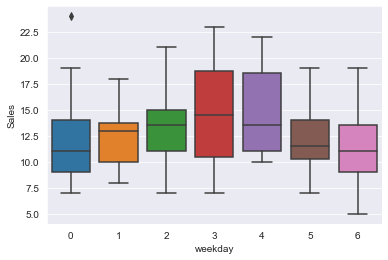

In [10]:
sns.boxplot(x="weekday", y="Sales", data=data[:100])

- Monday = 0; Sunday = 6
- There is not a distinct difference between sales made through out each day of the week. 
- Minimum sales made on Saturday
- Maximum sales made on Friday followed by Thursday
- No significant weekly seasonality


<AxesSubplot:xlabel='month', ylabel='Sales'>

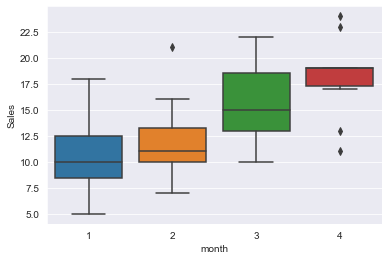

In [11]:
sns.boxplot(x="month", y="Sales", data=data[:100])

- January = 0; December = 6
- Sales are more in the middle of the year 
- Maximum sales observed in the month June, July
- Minimum sales observed at the start and end of the year : January, December

<Figure size 432x288 with 0 Axes>

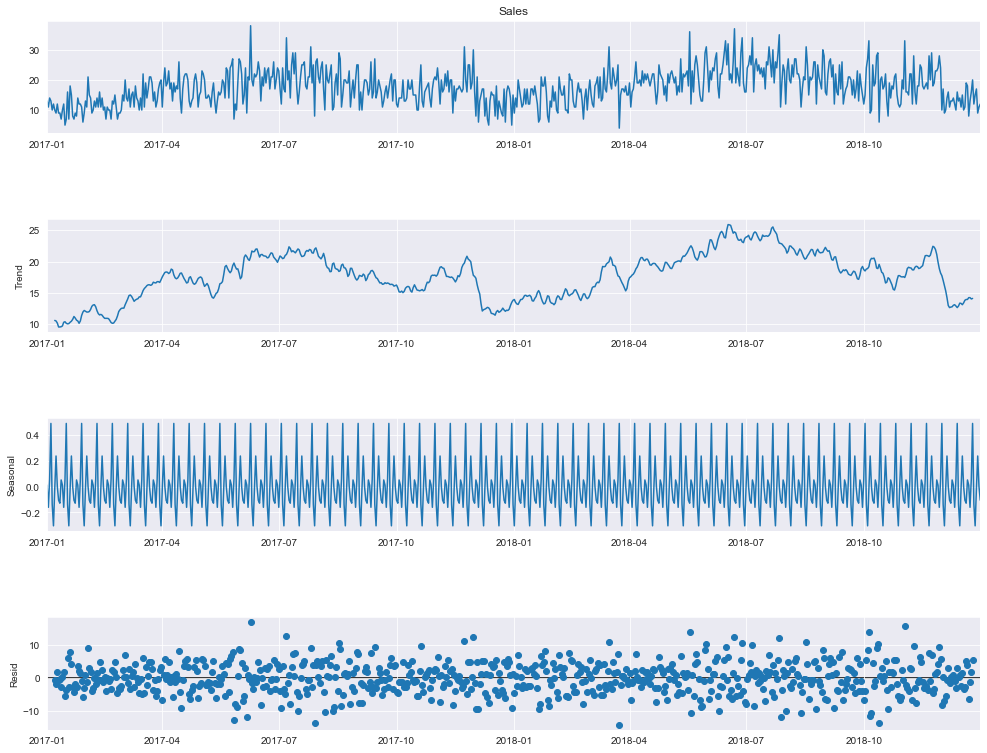

In [12]:
# Decomposition of the components of time series
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data['Sales'][:730], model='aditive', freq=12)

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 12)

In [13]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

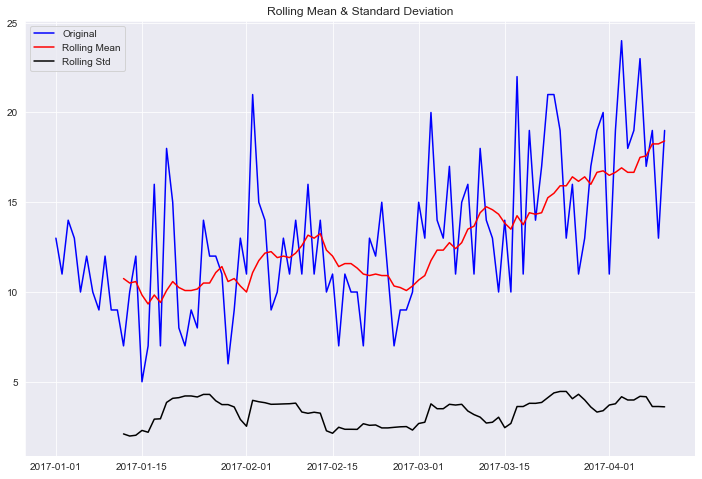

Results of Dickey-Fuller Test:
p-value = 0.0058. The series is likely stationary.
Test Statistic                 -3.597213
p-value                         0.005815
#Lags Used                      1.000000
Number of Observations Used    98.000000
Critical Value (1%)            -3.498910
Critical Value (5%)            -2.891516
Critical Value (10%)           -2.582760
dtype: float64


In [14]:
test_stationarity(data['Sales'][:100])

In [15]:
# first_diff = train.Sales - train.Sales.shift(1)
# first_diff = first_diff.dropna(inplace = False)
# test_stationarity(first_diff, window = 12)

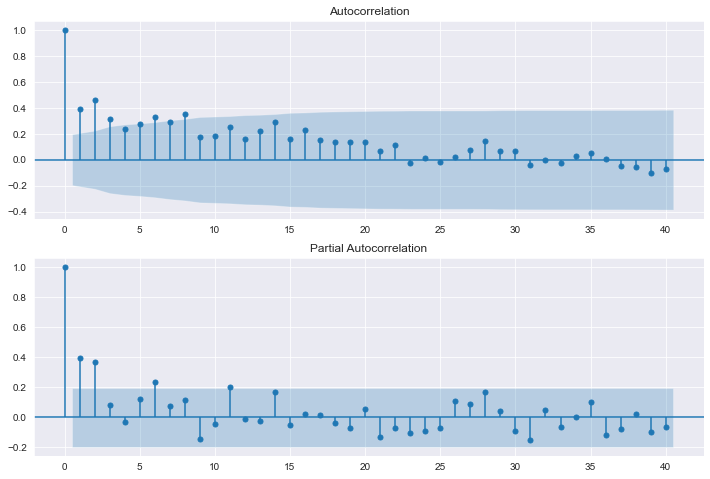

In [16]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data.Sales[:100], lags=40, ax=ax1) # 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data.Sales[:100], lags=40, ax=ax2)# , lags=40

In [17]:
# fig = plt.figure(figsize=(12,8))
# ax1 = fig.add_subplot(211)
# fig = sm.graphics.tsa.plot_acf(first_diff, lags=40, ax=ax1)
# ax2 = fig.add_subplot(212)
# fig = sm.graphics.tsa.plot_pacf(first_diff, lags=40, ax=ax2)

In [18]:
arima_mod6 = sm.tsa.ARIMA(data.Sales[:100], (1,1,0)).fit(disp=False)
print(arima_mod6.summary())

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


                             ARIMA Model Results                              
Dep. Variable:                D.Sales   No. Observations:                   99
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -273.536
Method:                       css-mle   S.D. of innovations              3.828
Date:                Sat, 02 Oct 2021   AIC                            553.073
Time:                        20:43:30   BIC                            560.858
Sample:                    01-02-2017   HQIC                           556.223
                         - 04-10-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0466      0.249      0.187      0.852      -0.441       0.534
ar.L1.D.Sales    -0.5516      0.084     -6.581      0.000      -0.716      -0.387
                                    Root

NormaltestResult(statistic=1.8970772034104635, pvalue=0.38730661930644006)


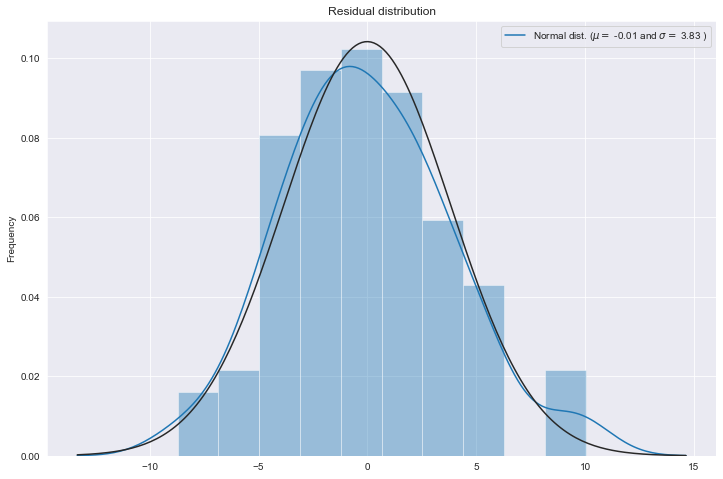

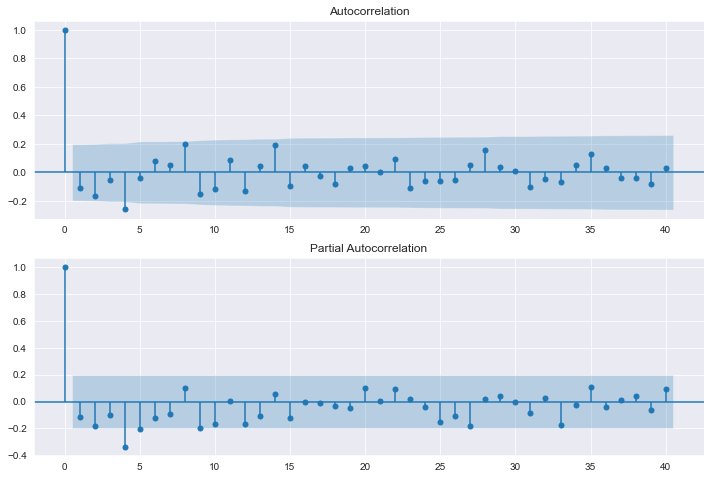

In [19]:
from scipy import stats
from scipy.stats import normaltest

resid = arima_mod6.resid
print(normaltest(resid))
# returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
# the residual is not a normal distribution

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_mod6.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_mod6.resid, lags=40, ax=ax2)

In [21]:
sarima_mod6 = sm.tsa.statespace.SARIMAX(data.Sales[:100], trend='n', order=(6,1,0)).fit()
print(sarima_mod6.summary())

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  100
Model:               SARIMAX(6, 1, 0)   Log Likelihood                -263.646
Date:                Sat, 02 Oct 2021   AIC                            541.292
Time:                        20:44:13   BIC                            559.458
Sample:                    01-01-2017   HQIC                           548.642
                         - 04-10-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7927      0.119     -6.641      0.000      -1.027      -0.559
ar.L2         -0.4188      0.132     -3.168      0.002      -0.678      -0.160
ar.L3         -0.3519      0.130     -2.703      0.0

NormaltestResult(statistic=13.515788574305725, pvalue=0.0011616727495002142)


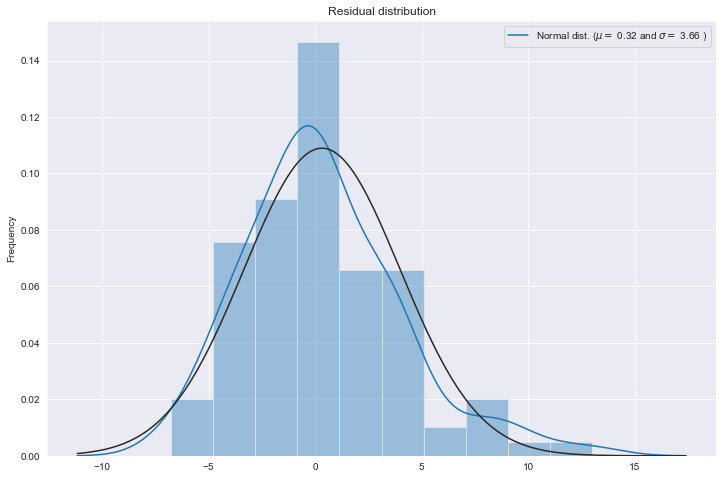

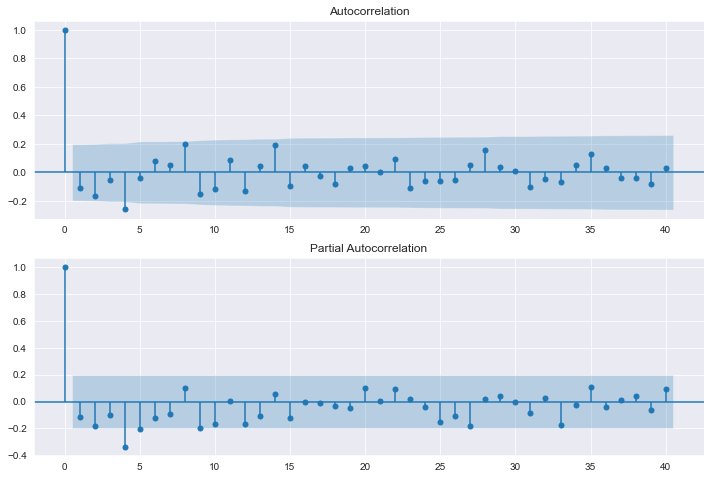

In [22]:
resid = sarima_mod6.resid
print(normaltest(resid))

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_mod6.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_mod6.resid, lags=40, ax=ax2)

<AxesSubplot:xlabel='Date'>

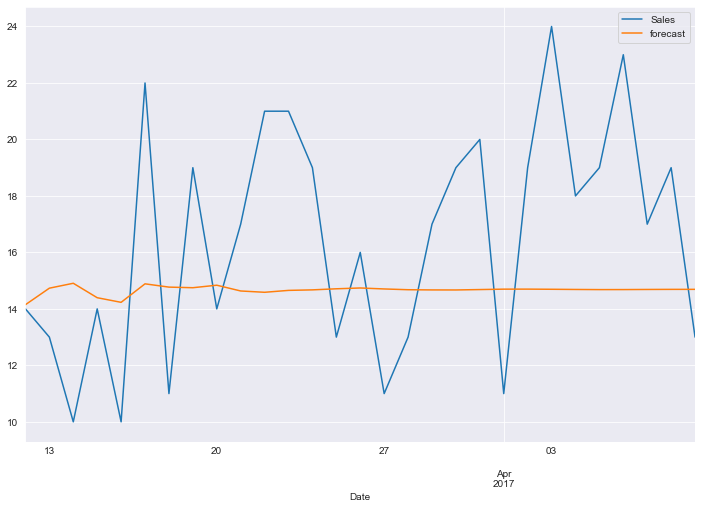

In [24]:
start_index = 70 
end_index = 99
data['forecast'] = sarima_mod6.predict(start = start_index, end= end_index, dynamic= True)  
data[start_index:end_index][['Sales', 'forecast']].plot(figsize=(12, 8))

In [25]:
def smape_kun(y_true, y_pred):
    mape = np.mean(abs((y_true-y_pred)/y_true))*100
    smape = np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))).fillna(0))
    print('MAPE: %.2f %% \nSMAPE: %.2f'% (mape,smape), "%")

In [30]:
smape_kun(data[72:99]['Sales'],data[72:99]['forecast'])

MAPE: 23.66 % 
SMAPE: 24.65 %
